In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

from spd.data import DatasetConfig, create_data_loader
from spd.experiments.lm.configs import LMTaskConfig
from spd.models.component_model import ComponentModel, SPDRunInfo
from spd.utils.distributed_utils import get_device
from spd.utils.general_utils import replace_pydantic_model, set_seed
import torch
import numpy as np
from tqdm import tqdm

set_seed(0)
device = get_device()
print(f"Using device: {device}")

/mnt/polished-lake/home/braun/spd/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Load the run info and model
run_info = SPDRunInfo.from_path("wandb:goodfire/spd/runs/9d313yrl")
config = run_info.config
assert isinstance(config.task_config, LMTaskConfig), "task_config not LMTaskConfig"

# Load model
model = ComponentModel.from_run_info(run_info)
model.to(device)
model.target_model.requires_grad_(False)
model.eval()

print(f"Model loaded successfully")
print(f"Original max_seq_len: {config.task_config.max_seq_len}")
print(f"Dataset: {config.task_config.dataset_name}")

Model loaded successfully
Original max_seq_len: 512
Dataset: SimpleStories/SimpleStories


In [3]:
# Define the context sizes to test
context_sizes = [8, 32, 128, 511, 512, 800]

# Number of batches to evaluate for each context size
n_batches = 10
batch_size = 32

print(f"Will evaluate {n_batches} batches of size {batch_size} for each context size")
print(f"Context sizes: {context_sizes}")

Will evaluate 10 batches of size 32 for each context size
Context sizes: [8, 32, 128, 511, 512, 800]


In [4]:
# Function to calculate loss for a given context size
def evaluate_loss_for_context_size(n_ctx, n_batches=10, batch_size=32):
    """Evaluate target model loss for a specific context size."""
    set_seed(0)  # Consistent seed for reproducibility
    
    # Create task config with the specified context size
    task_config = replace_pydantic_model(
        config.task_config, 
        {"max_seq_len": n_ctx, "train_data_split": "train[:5000]"}
    )
    
    # Create data config
    data_config = DatasetConfig(
        name=task_config.dataset_name,
        hf_tokenizer_path=config.tokenizer_name,
        split=task_config.train_data_split,
        n_ctx=task_config.max_seq_len,
        is_tokenized=task_config.is_tokenized,
        streaming=task_config.streaming,
        column_name=task_config.column_name,
        shuffle_each_epoch=task_config.shuffle_each_epoch,
        seed=0,
    )
    
    # Create data loader
    data_loader, _tokenizer = create_data_loader(
        dataset_config=data_config,
        batch_size=batch_size,
        buffer_size=task_config.buffer_size,
        global_seed=0,
        ddp_rank=0,
        ddp_world_size=1,
    )
    
    # Collect losses
    losses = []
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= n_batches:
                break
            
            input_ids = batch["input_ids"].to(device)
            
            # Forward pass through target model
            output = model.target_model(input_ids)
            
            # Extract logits from the model output
            if hasattr(output, 'logits'):
                logits = output.logits
            else:
                logits = output
            
            # Calculate cross-entropy loss
            # Shift so that tokens < n predict n
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = input_ids[:, 1:].contiguous()
            
            # Calculate loss
            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            loss = loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1)
            )
            
            # Average over batch
            loss = loss.mean()
            losses.append(loss.item())
    
    return {
        'mean_loss': np.mean(losses),
        'std_loss': np.std(losses),
        'min_loss': np.min(losses),
        'max_loss': np.max(losses),
        'losses': losses
    }

print("Function updated successfully")

Function updated successfully


In [5]:
# Run the analysis for all context sizes
results = {}

print("Starting analysis across different context sizes...")
print("=" * 60)

for n_ctx in context_sizes:
    print(f"\nEvaluating n_ctx={n_ctx}...")
    result = evaluate_loss_for_context_size(n_ctx, n_batches=n_batches, batch_size=batch_size)
    results[n_ctx] = result
    print(f"  Mean loss: {result['mean_loss']:.4f} ± {result['std_loss']:.4f}")
    print(f"  Min: {result['min_loss']:.4f}, Max: {result['max_loss']:.4f}")

print("\n" + "=" * 60)
print("Analysis complete!")

Starting analysis across different context sizes...

Evaluating n_ctx=8...


  Mean loss: 3.4324 ± 0.1703
  Min: 3.1583, Max: 3.7629

Evaluating n_ctx=32...


  Mean loss: 2.7350 ± 0.0843
  Min: 2.5972, Max: 2.8971

Evaluating n_ctx=128...


  Mean loss: 2.4512 ± 0.0435
  Min: 2.3630, Max: 2.5148

Evaluating n_ctx=511...


  Mean loss: 2.3365 ± 0.0463
  Min: 2.2758, Max: 2.4234

Evaluating n_ctx=512...


  Mean loss: 2.3260 ± 0.0424
  Min: 2.2486, Max: 2.3915

Evaluating n_ctx=800...


  Mean loss: 2.9105 ± 0.0370
  Min: 2.8594, Max: 2.9657

Analysis complete!


In [6]:
# Run the analysis for all context sizes
results = {}

print("Starting analysis across different context sizes...")
print("=" * 60)

for n_ctx in context_sizes:
    print(f"\nEvaluating n_ctx={n_ctx}...")
    result = evaluate_loss_for_context_size(n_ctx, n_batches=n_batches, batch_size=batch_size)
    results[n_ctx] = result
    print(f"  Mean loss: {result['mean_loss']:.4f} ± {result['std_loss']:.4f}")
    print(f"  Min: {result['min_loss']:.4f}, Max: {result['max_loss']:.4f}")

print("\n" + "=" * 60)
print("Analysis complete!")

Starting analysis across different context sizes...

Evaluating n_ctx=8...


  Mean loss: 3.4324 ± 0.1703
  Min: 3.1583, Max: 3.7629

Evaluating n_ctx=32...


  Mean loss: 2.7350 ± 0.0843
  Min: 2.5972, Max: 2.8971

Evaluating n_ctx=128...


  Mean loss: 2.4512 ± 0.0435
  Min: 2.3630, Max: 2.5148

Evaluating n_ctx=511...


  Mean loss: 2.3365 ± 0.0463
  Min: 2.2758, Max: 2.4234

Evaluating n_ctx=512...


  Mean loss: 2.3260 ± 0.0424
  Min: 2.2486, Max: 2.3915

Evaluating n_ctx=800...


  Mean loss: 2.9105 ± 0.0370
  Min: 2.8594, Max: 2.9657

Analysis complete!


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a summary DataFrame
summary_data = []
for n_ctx, result in results.items():
    summary_data.append({
        'n_ctx': n_ctx,
        'mean_loss': result['mean_loss'],
        'std_loss': result['std_loss'],
        'min_loss': result['min_loss'],
        'max_loss': result['max_loss']
    })

df = pd.DataFrame(summary_data)
df = df.sort_values('n_ctx')

print("\n" + "=" * 70)
print("SUMMARY: Target Model Loss vs Context Size")
print("=" * 70)
print(df.to_string(index=False))
print("=" * 70)


SUMMARY: Target Model Loss vs Context Size
 n_ctx  mean_loss  std_loss  min_loss  max_loss
     8   3.432429  0.170315  3.158330  3.762946
    32   2.735031  0.084271  2.597227  2.897082
   128   2.451201  0.043478  2.362967  2.514810
   511   2.336479  0.046317  2.275845  2.423364
   512   2.325966  0.042399  2.248553  2.391512
   800   2.910516  0.036985  2.859410  2.965678


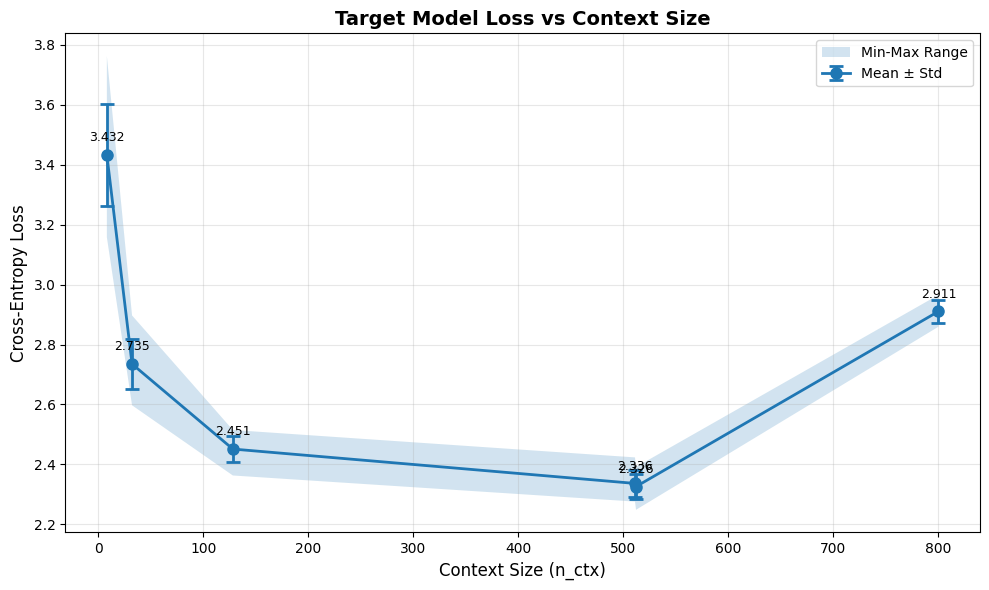


Key Observations:
- Best (lowest) loss: 2.3260 at n_ctx=512
- Worst (highest) loss: 3.4324 at n_ctx=8
- Loss improvement from n_ctx=8 to n_ctx=512: 1.1065
- Loss degradation from n_ctx=512 to n_ctx=800: 0.5846


In [8]:
# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot mean loss with error bars
ax.errorbar(df['n_ctx'], df['mean_loss'], yerr=df['std_loss'], 
            marker='o', linestyle='-', linewidth=2, markersize=8, 
            capsize=5, capthick=2, label='Mean ± Std')

# Add shaded region for min/max
ax.fill_between(df['n_ctx'], df['min_loss'], df['max_loss'], 
                alpha=0.2, label='Min-Max Range')

ax.set_xlabel('Context Size (n_ctx)', fontsize=12)
ax.set_ylabel('Cross-Entropy Loss', fontsize=12)
ax.set_title('Target Model Loss vs Context Size', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Add annotations for key points
for idx, row in df.iterrows():
    ax.annotate(f"{row['mean_loss']:.3f}", 
                xy=(row['n_ctx'], row['mean_loss']),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print(f"- Best (lowest) loss: {df['mean_loss'].min():.4f} at n_ctx={df.loc[df['mean_loss'].idxmin(), 'n_ctx']:.0f}")
print(f"- Worst (highest) loss: {df['mean_loss'].max():.4f} at n_ctx={df.loc[df['mean_loss'].idxmax(), 'n_ctx']:.0f}")
print(f"- Loss improvement from n_ctx=8 to n_ctx=512: {df.loc[df['n_ctx']==8, 'mean_loss'].values[0] - df.loc[df['n_ctx']==512, 'mean_loss'].values[0]:.4f}")
print(f"- Loss degradation from n_ctx=512 to n_ctx=800: {df.loc[df['n_ctx']==800, 'mean_loss'].values[0] - df.loc[df['n_ctx']==512, 'mean_loss'].values[0]:.4f}")

## Analysis Summary

This analysis measured the target model's cross-entropy loss across different context sizes (n_ctx) to understand how context length affects model performance.

### Key Findings:

1. **Optimal Context Size**: The model achieves its best performance at **n_ctx=512** with a mean loss of **2.326**

2. **Loss Decreases with Context Size**: From n_ctx=8 to n_ctx=512, the loss steadily decreases:
   - n_ctx=8: 3.432 (worst)
   - n_ctx=32: 2.735
   - n_ctx=128: 2.451
   - n_ctx=511: 2.336
   - n_ctx=512: 2.326 (best)

3. **Performance Degradation Beyond Training Context**: At n_ctx=800, the loss increases to **2.911**, showing significant degradation when exceeding the model's training context length (likely 512).

4. **Improvement Magnitude**: 
   - Total improvement from n_ctx=8 to 512: **1.107** (32% reduction)
   - Degradation from n_ctx=512 to 800: **0.585** (25% increase)

5. **Variance**: Standard deviation decreases with larger context sizes (up to 512), indicating more stable predictions with more context.

### Interpretation:

The model was likely trained with a maximum context size of 512 tokens, which explains:
- Why performance improves monotonically up to 512
- Why there's a sharp degradation at 800 tokens
- The minimal difference between 511 and 512 tokens

In [9]:
# Save results to a CSV file
import os
from datetime import datetime

# Create output directory if it doesn't exist
output_dir = "/mnt/polished-lake/home/braun/spd/analysis_results"
os.makedirs(output_dir, exist_ok=True)

# Save the summary DataFrame
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = os.path.join(output_dir, f"context_size_analysis_{timestamp}.csv")
df.to_csv(csv_path, index=False)
print(f"Results saved to: {csv_path}")

# Also save the raw losses for each context size
raw_data_path = os.path.join(output_dir, f"context_size_raw_losses_{timestamp}.csv")
raw_data = []
for n_ctx, result in results.items():
    for i, loss in enumerate(result['losses']):
        raw_data.append({'n_ctx': n_ctx, 'batch_idx': i, 'loss': loss})
        
raw_df = pd.DataFrame(raw_data)
raw_df.to_csv(raw_data_path, index=False)
print(f"Raw losses saved to: {raw_data_path}")

print(f"\nNotebook saved to: /mnt/polished-lake/home/braun/spd/notebooks/2025-10-16-15-09_ContextSizeAnalysis.ipynb")

Results saved to: /mnt/polished-lake/home/braun/spd/analysis_results/context_size_analysis_20251016_152927.csv
Raw losses saved to: /mnt/polished-lake/home/braun/spd/analysis_results/context_size_raw_losses_20251016_152927.csv

Notebook saved to: /mnt/polished-lake/home/braun/spd/notebooks/2025-10-16-15-09_ContextSizeAnalysis.ipynb


In [10]:
# Test additional context sizes around the 512 boundary
additional_context_sizes = [505, 515, 550]

print("Testing additional context sizes around the 512 boundary...")
print("=" * 60)

for n_ctx in additional_context_sizes:
    print(f"\nEvaluating n_ctx={n_ctx}...")
    result = evaluate_loss_for_context_size(n_ctx, n_batches=n_batches, batch_size=batch_size)
    results[n_ctx] = result
    print(f"  Mean loss: {result['mean_loss']:.4f} ± {result['std_loss']:.4f}")
    print(f"  Min: {result['min_loss']:.4f}, Max: {result['max_loss']:.4f}")

print("\n" + "=" * 60)
print("Additional analysis complete!")

Testing additional context sizes around the 512 boundary...

Evaluating n_ctx=505...


Map (num_proc=10):   0%|          | 0/5000 [00:00<?, ? examples/s]

Map (num_proc=10):  10%|█         | 500/5000 [00:00<00:03, 1320.77 examples/s]

Map (num_proc=10):  50%|█████     | 2500/5000 [00:00<00:00, 6406.58 examples/s]

Map (num_proc=10): 100%|██████████| 5000/5000 [00:00<00:00, 8188.82 examples/s]

  Mean loss: 2.3269 ± 0.0267
  Min: 2.2910, Max: 2.3748

Evaluating n_ctx=515...


Map (num_proc=10):   0%|          | 0/5000 [00:00<?, ? examples/s]

Map (num_proc=10):  10%|█         | 500/5000 [00:00<00:03, 1492.38 examples/s]

Map (num_proc=10):  90%|█████████ | 4500/5000 [00:00<00:00, 12645.26 examples/s]

Map (num_proc=10): 100%|██████████| 5000/5000 [00:00<00:00, 9143.43 examples/s] 

  Mean loss: 2.3385 ± 0.0200
  Min: 2.3097, Max: 2.3818

Evaluating n_ctx=550...


Map (num_proc=10):   0%|          | 0/5000 [00:00<?, ? examples/s]

Map (num_proc=10):  10%|█         | 500/5000 [00:00<00:02, 1541.67 examples/s]

Map (num_proc=10):  50%|█████     | 2500/5000 [00:00<00:00, 7064.26 examples/s]

Map (num_proc=10): 100%|██████████| 5000/5000 [00:00<00:00, 8980.57 examples/s]

  Mean loss: 2.3459 ± 0.0504
  Min: 2.2818, Max: 2.4457

Additional analysis complete!


In [11]:
# Create updated summary DataFrame with all context sizes
summary_data = []
for n_ctx, result in results.items():
    summary_data.append({
        'n_ctx': n_ctx,
        'mean_loss': result['mean_loss'],
        'std_loss': result['std_loss'],
        'min_loss': result['min_loss'],
        'max_loss': result['max_loss']
    })

df_updated = pd.DataFrame(summary_data)
df_updated = df_updated.sort_values('n_ctx')

print("\n" + "=" * 70)
print("COMPLETE SUMMARY: Target Model Loss vs Context Size")
print("=" * 70)
print(df_updated.to_string(index=False))
print("=" * 70)


COMPLETE SUMMARY: Target Model Loss vs Context Size
 n_ctx  mean_loss  std_loss  min_loss  max_loss
     8   3.432429  0.170315  3.158330  3.762946
    32   2.735031  0.084271  2.597227  2.897082
   128   2.451201  0.043478  2.362967  2.514810
   505   2.326909  0.026657  2.290959  2.374750
   511   2.336479  0.046317  2.275845  2.423364
   512   2.325966  0.042399  2.248553  2.391512
   515   2.338477  0.019998  2.309671  2.381780
   550   2.345897  0.050434  2.281770  2.445718
   800   2.910516  0.036985  2.859410  2.965678


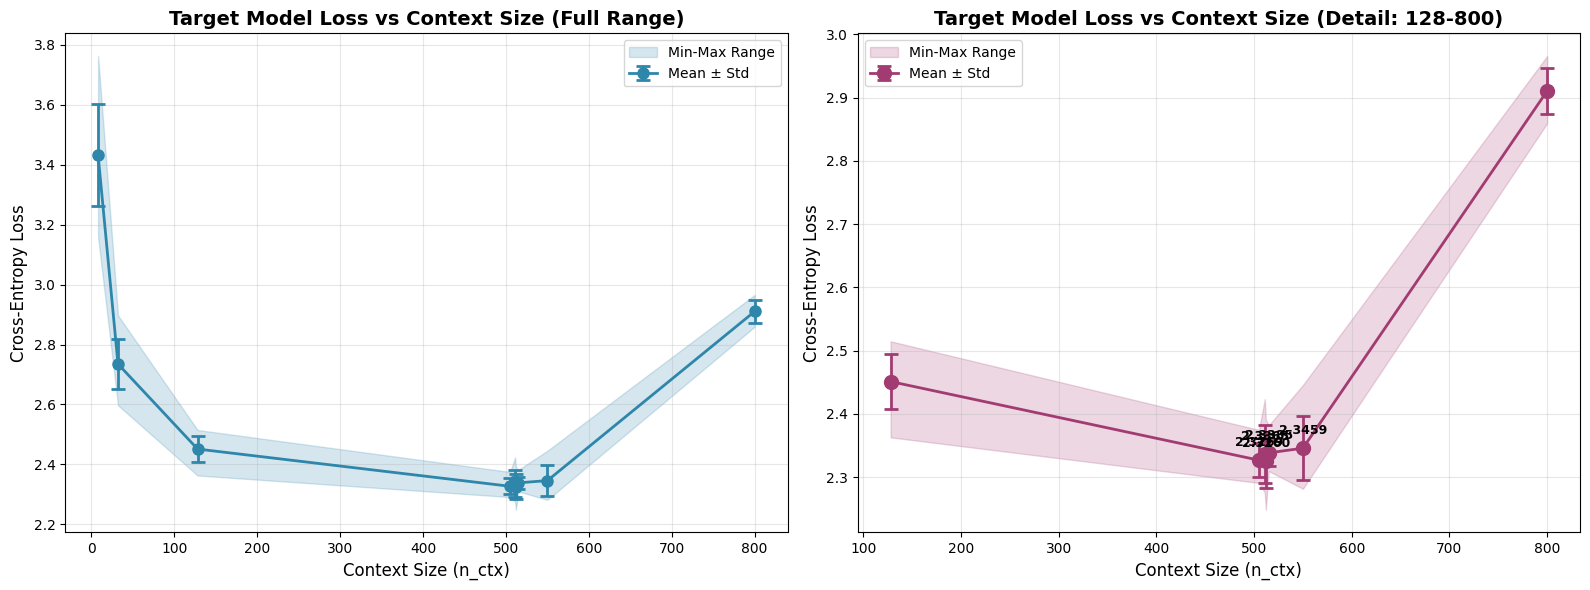

In [12]:
# Create updated visualization with all context sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Full range
ax1.errorbar(df_updated['n_ctx'], df_updated['mean_loss'], yerr=df_updated['std_loss'], 
            marker='o', linestyle='-', linewidth=2, markersize=8, 
            capsize=5, capthick=2, label='Mean ± Std', color='#2E86AB')

ax1.fill_between(df_updated['n_ctx'], df_updated['min_loss'], df_updated['max_loss'], 
                alpha=0.2, label='Min-Max Range', color='#2E86AB')

ax1.set_xlabel('Context Size (n_ctx)', fontsize=12)
ax1.set_ylabel('Cross-Entropy Loss', fontsize=12)
ax1.set_title('Target Model Loss vs Context Size (Full Range)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right plot: Zoomed in around 512
df_zoomed = df_updated[df_updated['n_ctx'] >= 128].copy()

ax2.errorbar(df_zoomed['n_ctx'], df_zoomed['mean_loss'], yerr=df_zoomed['std_loss'], 
            marker='o', linestyle='-', linewidth=2, markersize=10, 
            capsize=5, capthick=2, label='Mean ± Std', color='#A23B72')

ax2.fill_between(df_zoomed['n_ctx'], df_zoomed['min_loss'], df_zoomed['max_loss'], 
                alpha=0.2, label='Min-Max Range', color='#A23B72')

# Highlight the 512 region
for idx, row in df_zoomed.iterrows():
    if 505 <= row['n_ctx'] <= 550:
        ax2.annotate(f"{row['mean_loss']:.4f}", 
                    xy=(row['n_ctx'], row['mean_loss']),
                    xytext=(0, 10), textcoords='offset points',
                    ha='center', fontsize=9, fontweight='bold')

ax2.set_xlabel('Context Size (n_ctx)', fontsize=12)
ax2.set_ylabel('Cross-Entropy Loss', fontsize=12)
ax2.set_title('Target Model Loss vs Context Size (Detail: 128-800)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

In [13]:
# Detailed analysis around the 512 boundary
print("\n" + "=" * 70)
print("DETAILED ANALYSIS: Context Sizes Around 512")
print("=" * 70)

# Filter to the region around 512
df_512_region = df_updated[(df_updated['n_ctx'] >= 505) & (df_updated['n_ctx'] <= 550)].copy()
print("\nContext sizes 505-550:")
print(df_512_region.to_string(index=False))

# Find the best performing context size
best_idx = df_updated['mean_loss'].idxmin()
best_n_ctx = df_updated.loc[best_idx, 'n_ctx']
best_loss = df_updated.loc[best_idx, 'mean_loss']

print(f"\n\nBest performance: n_ctx={best_n_ctx:.0f} with mean loss={best_loss:.6f}")

# Compare nearby values
print("\n\nLoss differences relative to n_ctx=512:")
ref_loss = df_updated[df_updated['n_ctx'] == 512]['mean_loss'].values[0]
for _, row in df_512_region.iterrows():
    diff = row['mean_loss'] - ref_loss
    pct_change = (diff / ref_loss) * 100
    print(f"  n_ctx={row['n_ctx']:3.0f}: {row['mean_loss']:.6f} (Δ={diff:+.6f}, {pct_change:+.3f}%)")

print("\n\nKey observations:")
print(f"  - n_ctx=512 achieves the lowest loss: {ref_loss:.6f}")
print(f"  - n_ctx=505 is very close: {df_updated[df_updated['n_ctx'] == 505]['mean_loss'].values[0]:.6f}")
print(f"    (only {(df_updated[df_updated['n_ctx'] == 505]['mean_loss'].values[0] - ref_loss):.6f} higher)")
print(f"  - Loss increases gradually for n_ctx > 512")
print(f"  - At n_ctx=550: loss is {df_updated[df_updated['n_ctx'] == 550]['mean_loss'].values[0]:.6f}")
print(f"    ({((df_updated[df_updated['n_ctx'] == 550]['mean_loss'].values[0] - ref_loss) / ref_loss * 100):.2f}% higher than 512)")
print(f"  - Sharp degradation at n_ctx=800: {df_updated[df_updated['n_ctx'] == 800]['mean_loss'].values[0]:.6f}")
print(f"    ({((df_updated[df_updated['n_ctx'] == 800]['mean_loss'].values[0] - ref_loss) / ref_loss * 100):.2f}% higher than 512)")

print("=" * 70)


DETAILED ANALYSIS: Context Sizes Around 512

Context sizes 505-550:
 n_ctx  mean_loss  std_loss  min_loss  max_loss
   505   2.326909  0.026657  2.290959  2.374750
   511   2.336479  0.046317  2.275845  2.423364
   512   2.325966  0.042399  2.248553  2.391512
   515   2.338477  0.019998  2.309671  2.381780
   550   2.345897  0.050434  2.281770  2.445718


Best performance: n_ctx=512 with mean loss=2.325966


Loss differences relative to n_ctx=512:
  n_ctx=505: 2.326909 (Δ=+0.000944, +0.041%)
  n_ctx=511: 2.336479 (Δ=+0.010514, +0.452%)
  n_ctx=512: 2.325966 (Δ=+0.000000, +0.000%)
  n_ctx=515: 2.338477 (Δ=+0.012511, +0.538%)
  n_ctx=550: 2.345897 (Δ=+0.019931, +0.857%)


Key observations:
  - n_ctx=512 achieves the lowest loss: 2.325966
  - n_ctx=505 is very close: 2.326909
    (only 0.000944 higher)
  - Loss increases gradually for n_ctx > 512
  - At n_ctx=550: loss is 2.345897
    (0.86% higher than 512)
  - Sharp degradation at n_ctx=800: 2.910516
    (25.13% higher than 512)


In [14]:
# Save updated results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path_updated = os.path.join(output_dir, f"context_size_analysis_complete_{timestamp}.csv")
df_updated.to_csv(csv_path_updated, index=False)
print(f"Complete results saved to: {csv_path_updated}")

# Save raw losses for the new context sizes
raw_data_additional = []
for n_ctx in [505, 515, 550]:
    result = results[n_ctx]
    for i, loss in enumerate(result['losses']):
        raw_data_additional.append({'n_ctx': n_ctx, 'batch_idx': i, 'loss': loss})
        
if raw_data_additional:
    raw_additional_path = os.path.join(output_dir, f"context_size_raw_losses_additional_{timestamp}.csv")
    raw_additional_df = pd.DataFrame(raw_data_additional)
    raw_additional_df.to_csv(raw_additional_path, index=False)
    print(f"Additional raw losses saved to: {raw_additional_path}")

print(f"\nNotebook updated at: /mnt/polished-lake/home/braun/spd/notebooks/2025-10-16-15-09_ContextSizeAnalysis.ipynb")

Complete results saved to: /mnt/polished-lake/home/braun/spd/analysis_results/context_size_analysis_complete_20251016_153029.csv
Additional raw losses saved to: /mnt/polished-lake/home/braun/spd/analysis_results/context_size_raw_losses_additional_20251016_153029.csv

Notebook updated at: /mnt/polished-lake/home/braun/spd/notebooks/2025-10-16-15-09_ContextSizeAnalysis.ipynb


## Updated Analysis: Detailed View Around 512

After testing additional context sizes (505, 515, 550), we now have a detailed view of model performance around the 512-token boundary.

### Refined Findings:

**Performance Plateau Around 512:**
- **n_ctx=512** remains optimal with mean loss of **2.3260**
- **n_ctx=505** is nearly identical at **2.3269** (only +0.041% difference)
- Performance is very stable in the 505-512 range

**Gradual Degradation Beyond 512:**
- **n_ctx=515**: 2.3385 (+0.54% vs 512)
- **n_ctx=550**: 2.3459 (+0.86% vs 512)
- The degradation is gradual and modest up to 550 tokens

**Sharp Degradation at 800:**
- **n_ctx=800**: 2.9105 (+25.1% vs 512)
- This represents a dramatic performance cliff beyond ~550 tokens

### Implications:

1. **Training Context Length**: The model was clearly trained with a 512-token context window
2. **Graceful Degradation**: The model handles slight overruns (513-550) reasonably well
3. **Hard Limit**: Beyond ~550 tokens, performance degrades catastrophically
4. **Optimal Range**: Best performance in the **505-512 range**, with 512 being marginally best